Import the libraries necessary to analize data

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv('df_scaled.csv')

Since we use distance metric working on numerical features we remove the categorical data and useless features 

In [3]:
column_to_drop = ['avg_age_participants','n_participants','n_participants_child', 'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'isKilled', 'involve_injury','pc1', 'pc2']

for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['avg_age_participants',
 'n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'isKilled',
 'involve_injury',
 'pc1',
 'pc2',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [4]:
df_categorical = df[column_to_drop].copy()
df_numeric = df.drop(columns=column_to_drop)

In [5]:
df_categorical.info()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   avg_age_participants       166664 non-null  float64
 1   n_participants             166664 non-null  float64
 2   n_participants_child       166664 non-null  int64  
 3   n_participants_teen        166664 non-null  int64  
 4   n_females                  166664 non-null  float64
 5   n_killed                   166664 non-null  float64
 6   n_injured                  166664 non-null  float64
 7   n_arrested                 166664 non-null  float64
 8   n_unharmed                 166664 non-null  float64
 9   date                       166664 non-null  object 
 10  latitude                   166664 non-null  float64
 11  longitude                  166664 non-null  float64
 12  congressional_district     166664 non-null  int64  
 13  candidatevotes             16

# K-means

In [6]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score

Knee Method to estimate the best K. 

We performed a nested grid search on k.

In [24]:
k_grid = [2, 3, 4, 10, 20, 30, 50, 100]

sse_list = list()

label_list = []
dict_kmeans = {}
#search for the best k
for k in k_grid:

    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_numeric)
    
    sse = kmeans.inertia_
    labels = kmeans.labels_
    #we save a list of see and labels for each k-means tried
    dict_kmeans[f'{k}_sse'] = sse
    dict_kmeans[f'{k}_labels'] = labels

    print(f'k: {k}, SSE: {sse}')


k: 2, SSE: 1646705.0224939003
k: 3, SSE: 1366709.6407480063
k: 4, SSE: 1208515.377290663
k: 10, SSE: 832829.6358275173
k: 20, SSE: 638844.1031324815
k: 30, SSE: 522498.1948609161
k: 50, SSE: 403826.66438311123
k: 100, SSE: 288556.6939906179


In [25]:
for k in k_grid:
    print(f'for k = {k}')
    
    print('SSE %s' % dict_kmeans[f'{k}_sse'])
    current_bouldin = metrics.davies_bouldin_score(df_numeric, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_bouldin_score'] = current_bouldin
    print('Separation %s' % current_bouldin)
    
    current_silhouette = silhouette_score(df_numeric, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_silhouette_score'] = current_silhouette
    print('Silhouette %s' % current_silhouette)

for k = 2
SSE 1646705.0224939003
Separation 1.981355504698109
Silhouette 0.19903324292775984
for k = 3
SSE 1366709.6407480063
Separation 1.5839778549346653
Silhouette 0.25429645599513645
for k = 4
SSE 1208515.377290663
Separation 1.3734583990523597
Silhouette 0.26406768002147735
for k = 10
SSE 832829.6358275173
Separation 1.4948593471140437
Silhouette 0.2642339840633822
for k = 20
SSE 638844.1031324815
Separation 1.5156825316113194
Silhouette 0.24407259637442938
for k = 30
SSE 522498.1948609161
Separation 1.354858209154389
Silhouette 0.24967789678610375
for k = 50
SSE 403826.66438311123
Separation 1.29426773313719
Silhouette 0.24230217592467848
for k = 100
SSE 288556.6939906179
Separation 1.325181186914798
Silhouette 0.24726976475349424


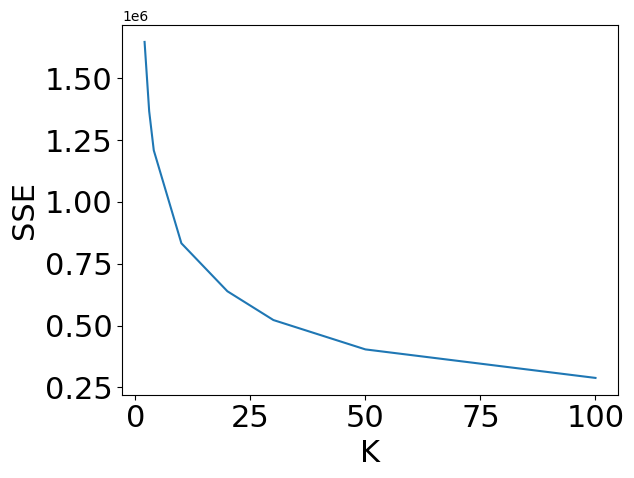

In [30]:
k_grid =  [2, 3, 4, 10, 20, 30, 50, 100]
sse_list = [dict_kmeans[f'{k}_sse'] for k in k_grid]
plt.plot(k_grid,sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', labelsize=22)
plt.show()

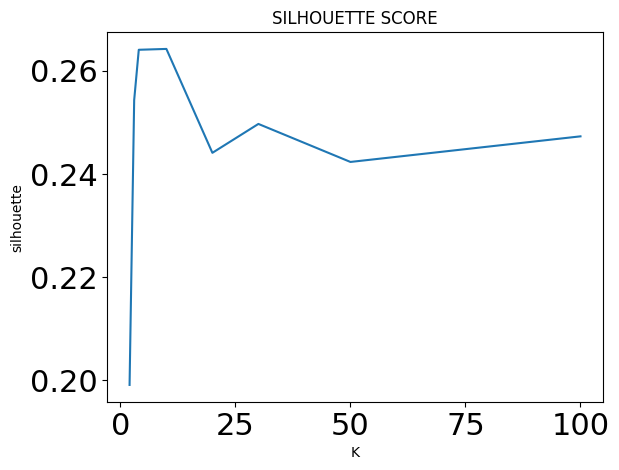

In [43]:
silhouette_list = [dict_kmeans[f'{k}_silhouette_score'] for k in k_grid]
plt.plot(k_grid, silhouette_list)
plt.ylabel('silhouette')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('SILHOUETTE SCORE')
#plt.axvline(6)
plt.show()

From both elbow method and silhouette score, best K is around 4.

In [7]:
#RETRAIN BEST K-MEANS
best_k = 4
best_kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=100)
best_kmeans.fit(df_numeric)

KMeans(max_iter=100, n_clusters=4, n_init=10)

In [10]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(best_kmeans.labels_))

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(best_kmeans.labels_ == k))

print('cluster sizes:', occ_list)

cluster sizes: [66857, 33380, 39833, 26594]


Plotting the result of the clustering on the pca dimensions (pc1 and pc2), labelling each point by the cluster label

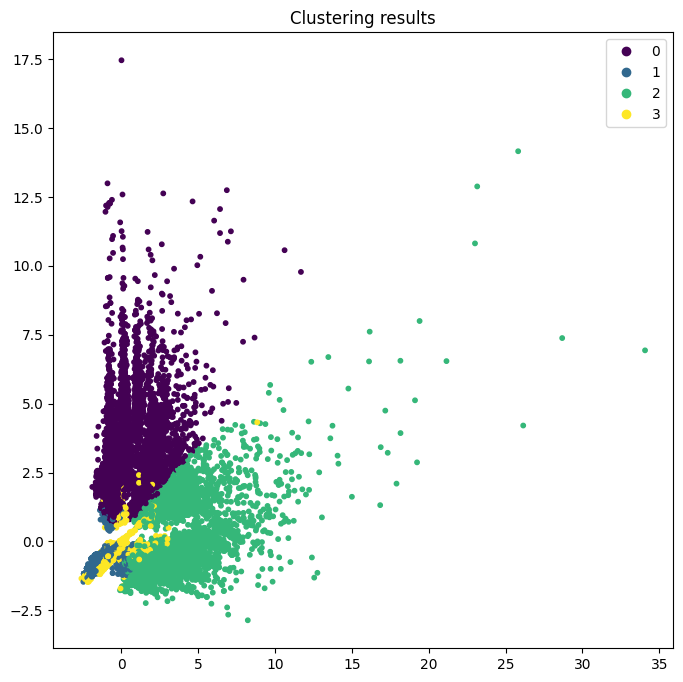

In [49]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(df['pc1'], df['pc2'], c=best_kmeans.labels_, s=10)

plt.tick_params(axis='both', which='major')
plt.title("Clustering results")
plt.legend(*scatter.legend_elements())

Plot of cluster labels distribution

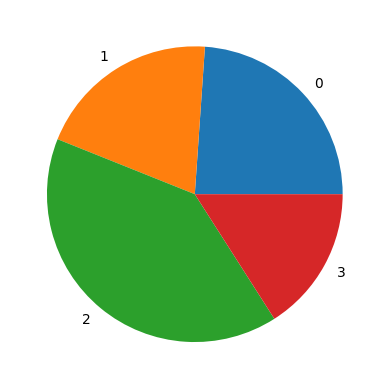

In [50]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

Involve_killing or not distribution

As we can see the number of killed persons in 2 out of 3 clusters is 0.

Radiant plot

0
ok [0.0, 0.5235987755982988, 1.0471975511965976, 1.5707963267948966, 2.0943951023931953, 2.6179938779914944, 3.141592653589793, 3.6651914291880923, 4.1887902047863905, 4.71238898038469, 5.235987755982989, 5.759586531581287, 0.0]
1
ok [0.0, 0.5235987755982988, 1.0471975511965976, 1.5707963267948966, 2.0943951023931953, 2.6179938779914944, 3.141592653589793, 3.6651914291880923, 4.1887902047863905, 4.71238898038469, 5.235987755982989, 5.759586531581287, 0.0]
2
ok [0.0, 0.5235987755982988, 1.0471975511965976, 1.5707963267948966, 2.0943951023931953, 2.6179938779914944, 3.141592653589793, 3.6651914291880923, 4.1887902047863905, 4.71238898038469, 5.235987755982989, 5.759586531581287, 0.0]
3
ok [0.0, 0.5235987755982988, 1.0471975511965976, 1.5707963267948966, 2.0943951023931953, 2.6179938779914944, 3.141592653589793, 3.6651914291880923, 4.1887902047863905, 4.71238898038469, 5.235987755982989, 5.759586531581287, 0.0]


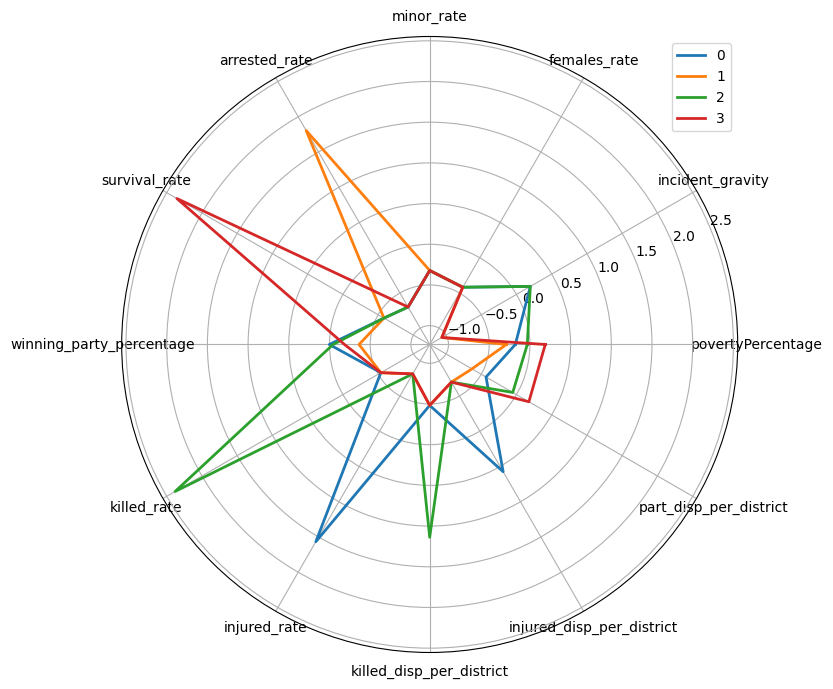

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import math

N = len(df_numeric.columns)
plt.figure(figsize=(8, 8))

for k in range(0, n_clusters):
    print(k)
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
     
    values = df_numeric[best_kmeans.labels_ == k].median().values.tolist()
    values += values[:1]
    angles += angles[:1]
    ax = plt.subplot(polar=True)
    plt.xticks(angles[:-1], df_numeric.columns)
    ax.plot(angles, values, linewidth=2)


plt.legend(labels=np.unique(best_kmeans.labels_))

plt.show()


Line plot

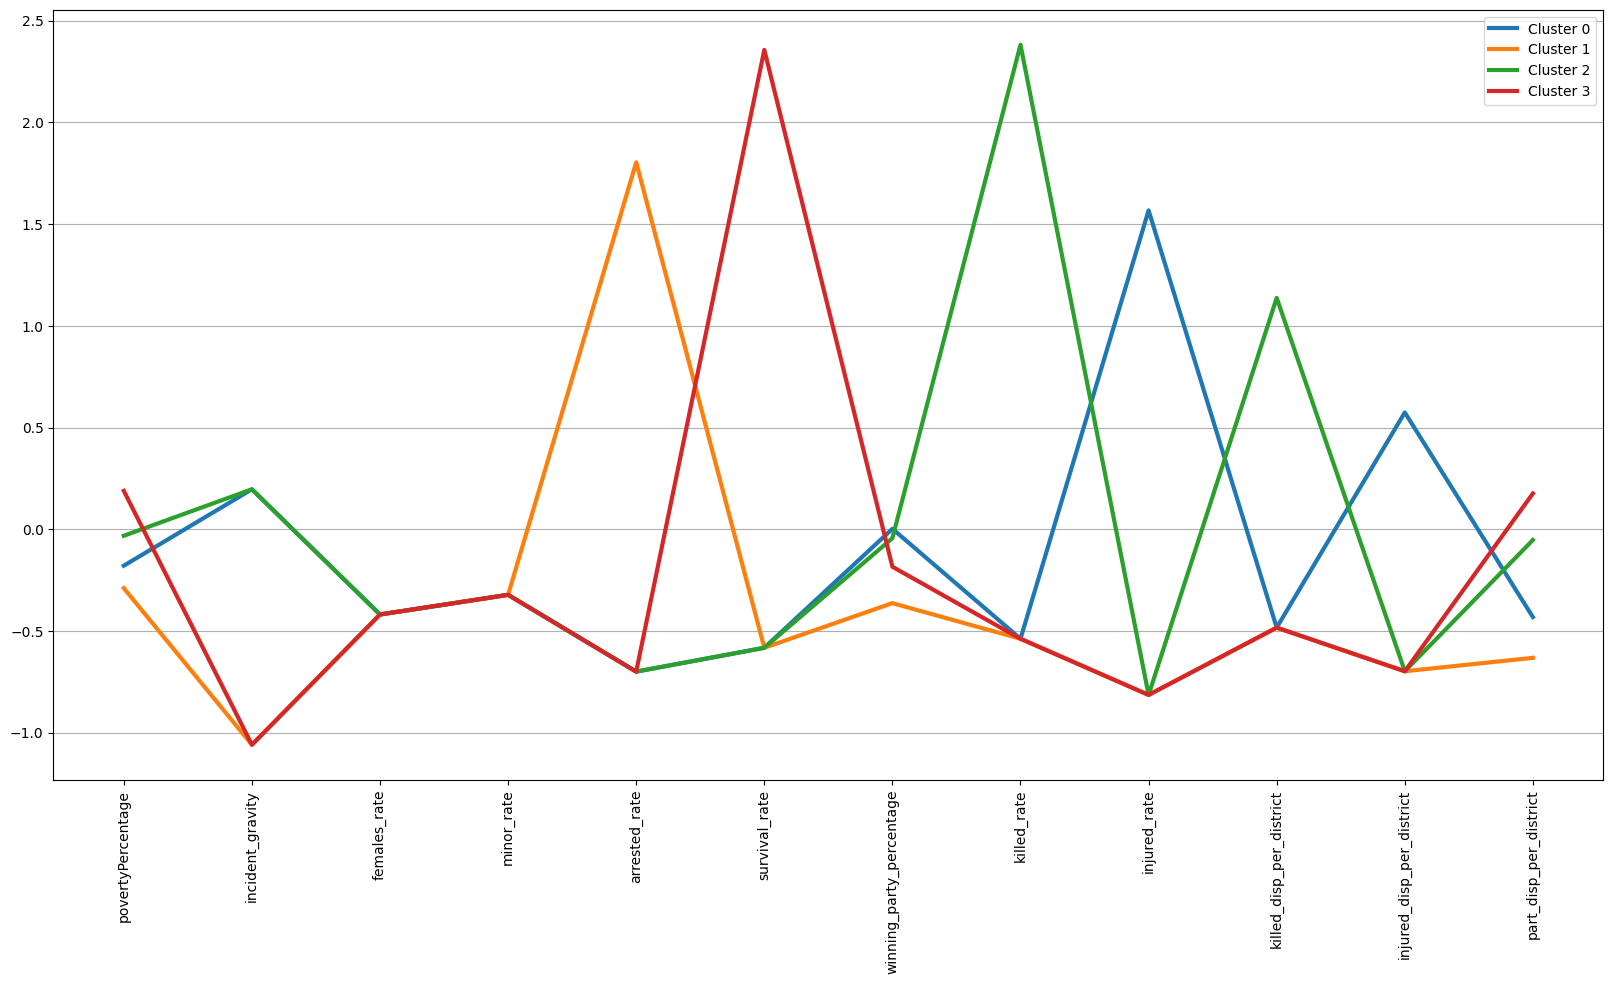

In [17]:
plt.figure(figsize=(20, 10))

for label in np.unique(best_kmeans.labels_):
    cent = df_numeric[best_kmeans.labels_ == label].median()
    plt.plot(cent, label="Cluster %s" % label, linewidth=3)
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(df_numeric.columns)), df_numeric.columns, rotation=90)
plt.legend()
plt.gca().yaxis.grid(True)

plt.show()

From the Line Plot and the Radar Plot it's becomes evident that the 4 clusters are influenced by 4 distinct feature or couple of features

## Characterizing clusters with States

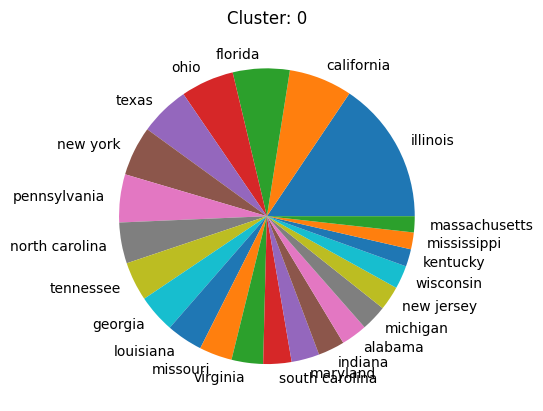

state
illinois          8943
california        3978
florida           3566
ohio              3343
texas             3132
new york          3114
pennsylvania      3016
north carolina    2569
tennessee         2449
georgia           2395
louisiana         2275
missouri          2062
virginia          1977
south carolina    1772
maryland          1753
indiana           1665
alabama           1631
michigan          1628
new jersey        1513
wisconsin         1459
kentucky          1095
mississippi       1056
massachusetts     1009
Name: count, dtype: int64


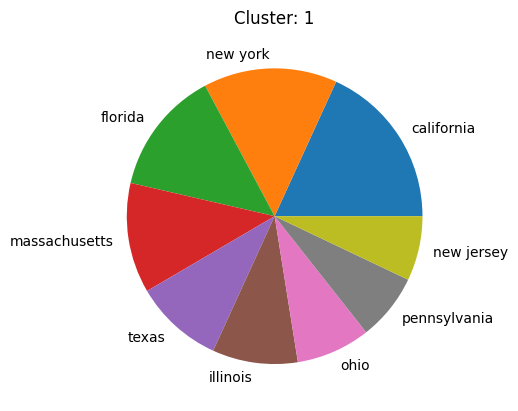

state
california       2749
new york         2212
florida          2056
massachusetts    1823
texas            1474
illinois         1412
ohio             1227
pennsylvania     1105
new jersey       1069
Name: count, dtype: int64


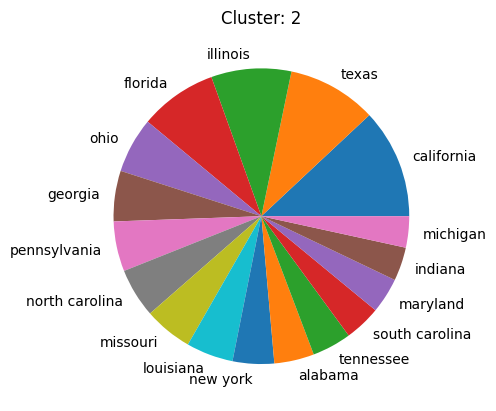

state
california        3505
texas             2855
illinois          2562
florida           2479
ohio              1779
georgia           1617
pennsylvania      1600
north carolina    1578
missouri          1549
louisiana         1505
new york          1327
alabama           1276
tennessee         1256
south carolina    1162
maryland          1135
indiana           1075
michigan          1001
Name: count, dtype: int64


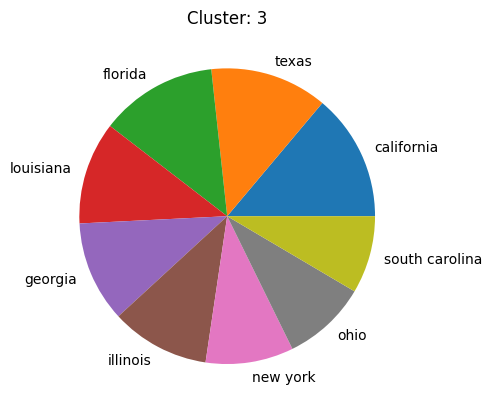

state
california        1743
texas             1614
florida           1612
louisiana         1411
georgia           1389
illinois          1359
new york          1208
ohio              1161
south carolina    1066
Name: count, dtype: int64


In [25]:
for k in range(0, n_clusters):
    # Get 'bot' values for elems in cluster k
    injury_for_clust = df_categorical['state'].loc[best_kmeans.labels_ == k].value_counts() 
    injury_for_clust = injury_for_clust[injury_for_clust > 1000]
    # Show pie plot
    plt.title('Cluster: ' + str(k))
    plt.pie(injury_for_clust, labels= injury_for_clust.index)
    plt.show()
    print(injury_for_clust)

We can notice that there is no a particular distinction between the top States for each cluster, with almost the same top States in a different order.

##  Characterizing clusters with incident char

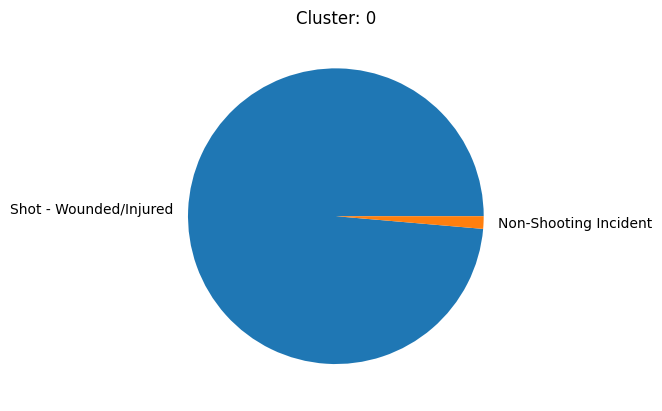

incident_characteristics1
Shot - Wounded/Injured    64877
Non-Shooting Incident       901
Name: count, dtype: int64


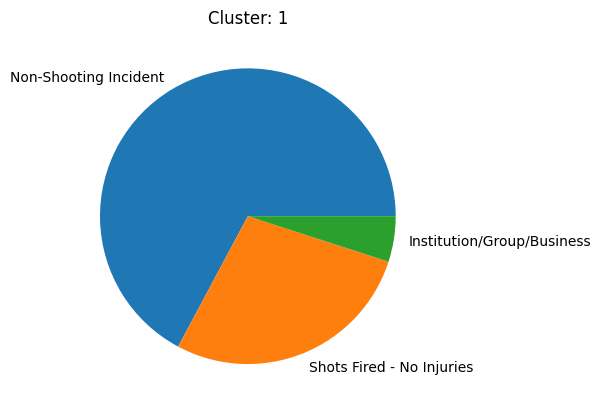

incident_characteristics1
Non-Shooting Incident         21029
Shots Fired - No Injuries      8713
Institution/Group/Business     1558
Name: count, dtype: int64


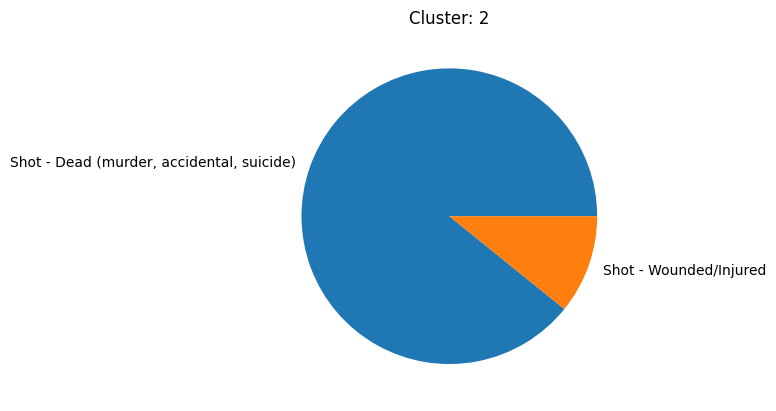

incident_characteristics1
Shot - Dead (murder, accidental, suicide)    35291
Shot - Wounded/Injured                        4279
Name: count, dtype: int64


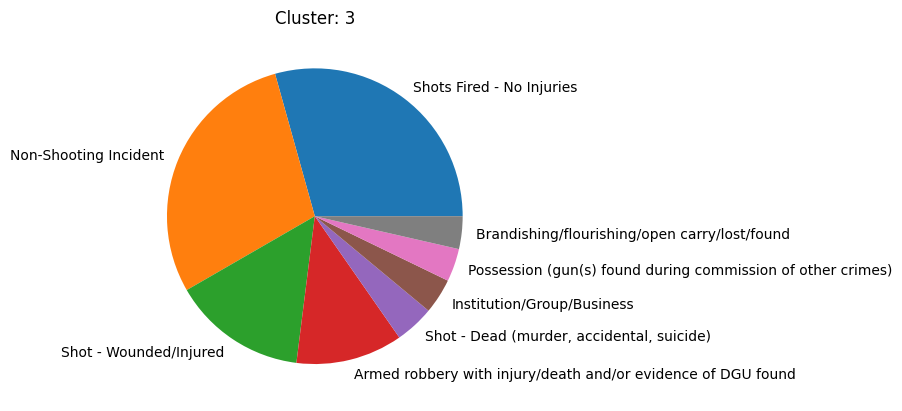

incident_characteristics1
Shots Fired - No Injuries                                       6909
Non-Shooting Incident                                           6828
Shot - Wounded/Injured                                          3458
Armed robbery with injury/death and/or evidence of DGU found    2749
Shot - Dead (murder, accidental, suicide)                       1008
Institution/Group/Business                                       908
Possession (gun(s) found during commission of other crimes)      849
Brandishing/flourishing/open carry/lost/found                    842
Name: count, dtype: int64


In [19]:
for k in range(0, n_clusters):
    incident_char_clust = df_categorical['incident_characteristics1'].loc[best_kmeans.labels_ == k].value_counts() 
    incident_char_clust = incident_char_clust[incident_char_clust > 800]
    # Show pie plot
    plt.title('Cluster: ' + str(k))
    plt.pie(incident_char_clust, labels= incident_char_clust.index)
    plt.show()
    print(incident_char_clust)

## Characterizing clusters with arrested, unharmed, killing, injuried

In [20]:
df_task_1 = pd.read_csv('../TASK1/df_after_dp.csv')

In [21]:
df_categorical.loc[df_task_1['n_arrested'] > 0, 'involve_arrest'] = 1
df_categorical.loc[df_task_1['n_arrested'] == 0, 'involve_arrest'] = 0

df_categorical.loc[df_task_1['n_unharmed'] > 0, 'involve_unharmed'] = 1
df_categorical.loc[df_task_1['n_unharmed'] == 0, 'involve_unharmed'] = 0

In [22]:
color_map = {0: 'royalblue', 1: 'darkslategrey'}

def get_colors(data):
    return [color_map[val] for val in data.index]

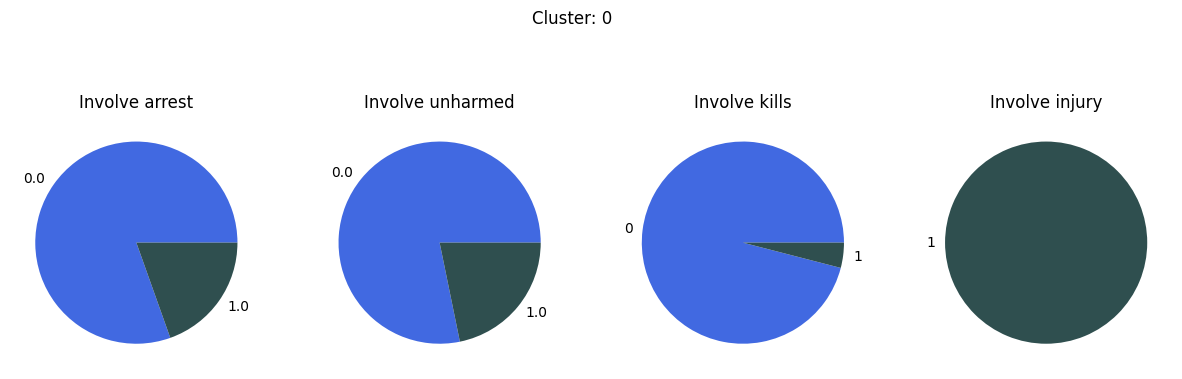

involve_arrest
0.0    53785
1.0    13072
Name: count, dtype: int64

involve_unharmed
0.0    52293
1.0    14564
Name: count, dtype: int64

isKilled
0    64168
1     2689
Name: count, dtype: int64

involve_injury
1    66857
Name: count, dtype: int64


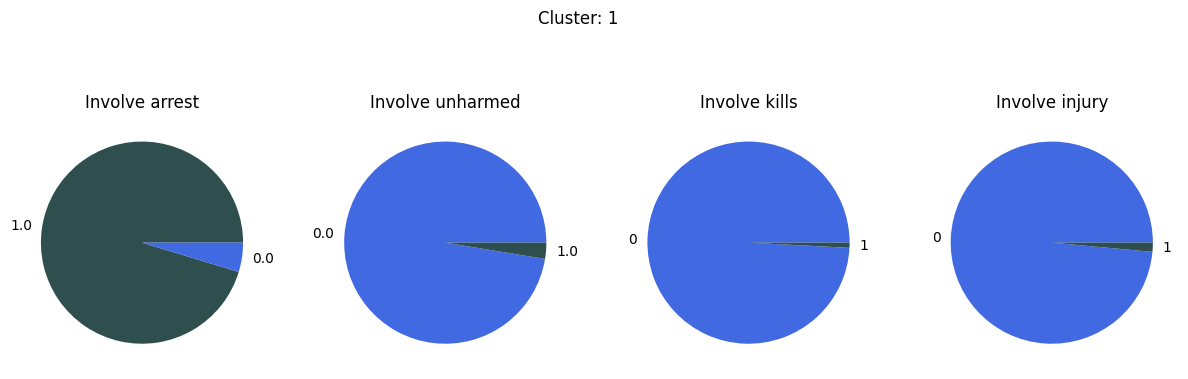

involve_arrest
1.0    31816
0.0     1564
Name: count, dtype: int64

involve_unharmed
0.0    32520
1.0      860
Name: count, dtype: int64

isKilled
0    33106
1      274
Name: count, dtype: int64

involve_injury
0    32894
1      486
Name: count, dtype: int64


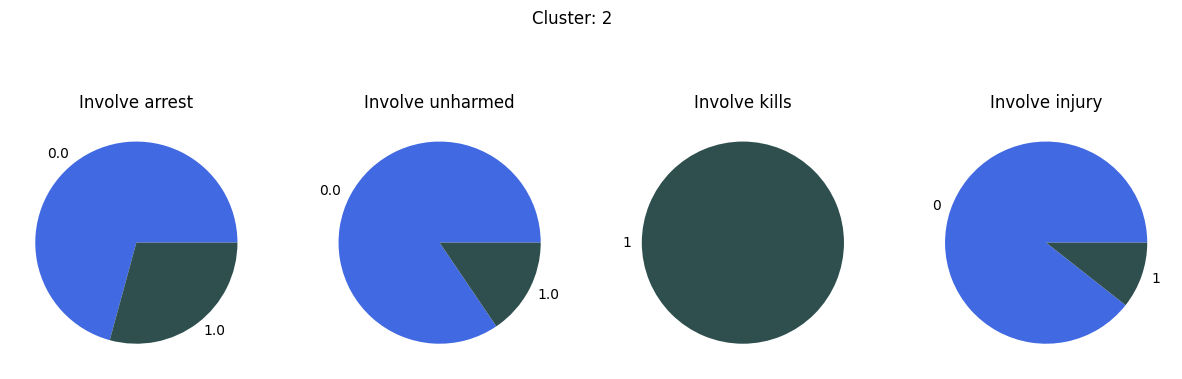

involve_arrest
0.0    28186
1.0    11647
Name: count, dtype: int64

involve_unharmed
0.0    33651
1.0     6182
Name: count, dtype: int64

isKilled
1    39833
Name: count, dtype: int64

involve_injury
0    35604
1     4229
Name: count, dtype: int64


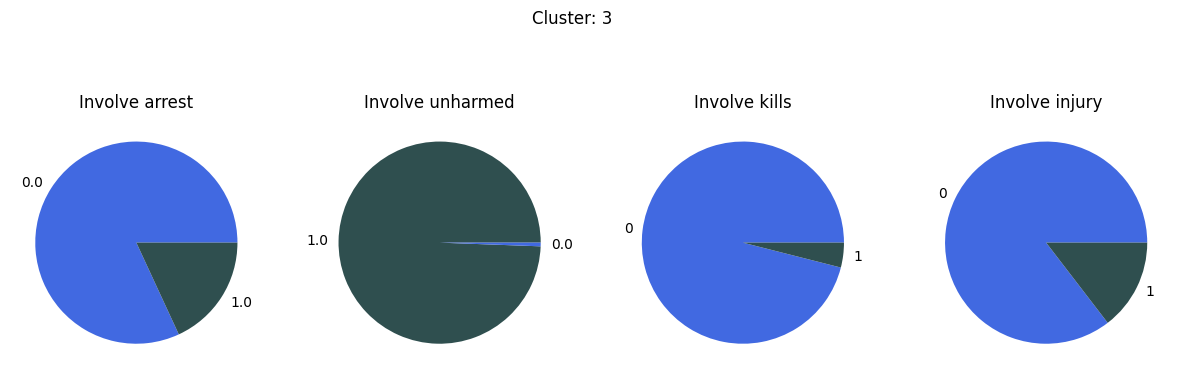

involve_arrest
0.0    21780
1.0     4814
Name: count, dtype: int64

involve_unharmed
1.0    26439
0.0      155
Name: count, dtype: int64

isKilled
0    25540
1     1054
Name: count, dtype: int64

involve_injury
0    22717
1     3877
Name: count, dtype: int64


In [24]:

for k in range(0, n_clusters):
    # Get 'bot' values for elems in cluster k
    
    n_arrested_clust =  df_categorical["involve_arrest"].loc[best_kmeans.labels_ == k].value_counts()
    n_unharmed_clust = df_categorical['involve_unharmed'].loc[best_kmeans.labels_  == k].value_counts() 
    n_killed_clust = df_categorical['isKilled'].loc[best_kmeans.labels_ == k].value_counts()
    n_injured_clust = df_categorical['involve_injury'].loc[best_kmeans.labels_ == k].value_counts()

    #showing the two pie plots together
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.suptitle('Cluster: ' + str(k))
    fig.set_figwidth(15)
    ax1.pie(n_arrested_clust, labels= n_arrested_clust.index, colors=get_colors(n_arrested_clust))
    ax2.pie(n_unharmed_clust, labels= n_unharmed_clust.index, colors=get_colors(n_unharmed_clust))
    ax3.pie(n_killed_clust, labels= n_killed_clust.index, colors=get_colors(n_killed_clust))
    ax4.pie(n_injured_clust, labels= n_injured_clust.index, colors=get_colors(n_injured_clust))

    #adding ax1 and ax2 titles
    ax1.set_title('Involve arrest')
    ax2.set_title('Involve unharmed')
    ax3.set_title('Involve kills')
    ax4.set_title('Involve injury')

    #change the colors of the pie plots
    

    plt.show()

    print(n_arrested_clust)
    print()
    print(n_unharmed_clust)
    print()
    print(n_killed_clust)
    print()
    print(n_injured_clust)


From the Pie Plots' outcomes, aligned with the radar plot findings, we've discerned four distinct clusters, each associated with a specific attribute: involvement in arrest, involvement in unharmed, killing, and involvement in injury. These attributes delineate four distinct incident types. Furthermore, examining the Pie Plots for incident characteristics reveals unique predominant traits within each cluster, aligning with their respective key features. For instance, Cluster 3, linked to the fatality attribute, predominantly exhibits incidents categorized as Shot - Dead (including murder, accidental deaths, or suicides). On the other hand, Cluster 0, associated with arrests, is related to minor offenses, such as non-use of firearms or firearms shots that resulted in no injuries.

# X Means 
#### from: https://github.com/annoviko/pyclustering/

In [23]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn import metrics
from sklearn.metrics import silhouette_score

In [157]:
start_centroids = 4
start_clusters = kmeans_plusplus_initializer(df_numeric, start_centroids, random_state=42).initialize()

#With k max = 200, it gives 200 clusters! Seems returing always the max number of clusters
#x_means = xmeans(df_numeric, start_clusters, tolerance=1e-6, kmax=200, repeat=10, random_state=42)


x_means = xmeans(df_numeric, start_clusters, tolerance=1e-6, kmax=10, repeat=10, random_state=42)
x_means.process()
 
# Clustering results:
print(f'Number of clusters found:', np.shape(x_means.get_centers())[0])
print("SSE:", x_means.get_total_wce())

Number of clusters found: 10
SSE: 875505.8809248749


In [158]:
labels = {}
clusters = x_means.get_clusters()
n_clusters = np.shape(clusters)[0]
#transforming each cluster list from [[cluster1 m points], ...., [clustern p points]] to [[1,1,,....,1 m times], [n,....,n p times]] 
#to {point1:labelcluster1,...., pointm:labelcluster1, ....., point1:labelclustern, ...., pointp:labelclustern} sorted by number of example.
for cluster_label in range(0, n_clusters):
  for i in range(0, len(clusters[cluster_label])):
      labels[clusters[cluster_label][i]] = cluster_label

labels = dict(sorted(labels.items()))
xmeans_labels = list(labels.values())

/Users/lau/Library/Python/3.11/lib/python/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
print('Separation %s' % metrics.davies_bouldin_score(df_numeric, xmeans_labels)) # lower value, better clustering (minimum zero)
print('Silhouette %s' % silhouette_score(df_numeric, xmeans_labels))

Separation 1.5469668353702986
Silhouette 0.2876653599956561


In [159]:
# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(np.array(xmeans_labels) == k))

print('cluster occurrencies:', occ_list)

cluster occurrencies: [45458, 9663, 3423, 7089, 28469, 7276, 5245, 10835, 18250, 30956]


Plot of cluster labels distribution

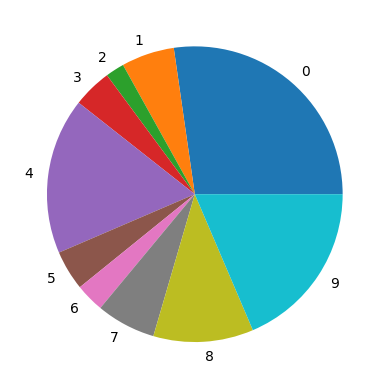

In [160]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show() 

We can see from distribution that the number of records are not really well distributed, we will probably test more and see what happens later.

Radiant plot

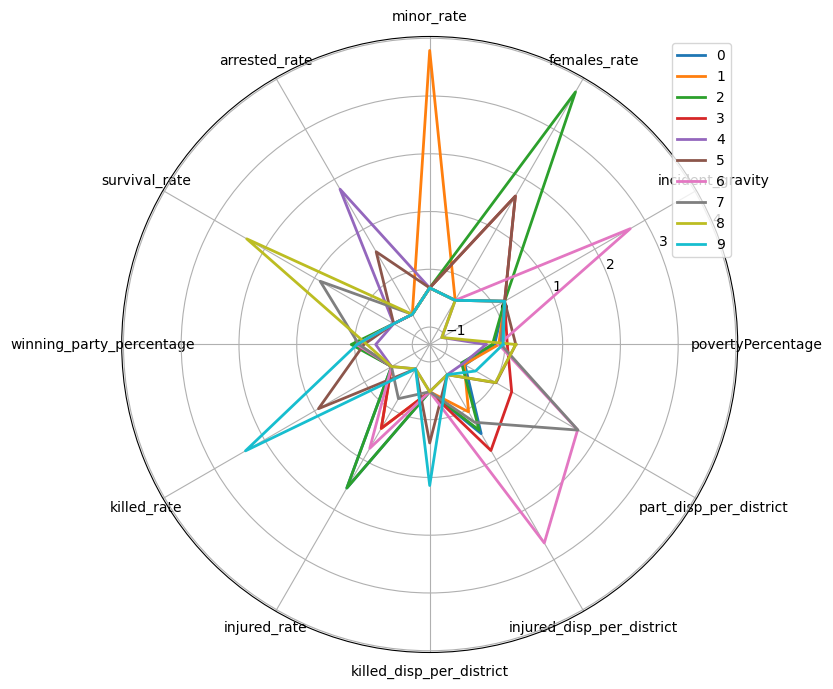

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import math

N = len(df_numeric.columns)
plt.figure(figsize=(8, 8))

labels_x = np.array(xmeans_labels)

for k in range(0, n_clusters):
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    
    values = df_numeric[labels_x == k].median().values.tolist()
    
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)
    plt.xticks(angles[:-1], df_numeric.columns)
    ax.plot(angles, values, linewidth=2)


plt.legend(labels=np.unique(labels_x))

plt.show()


Line Plot

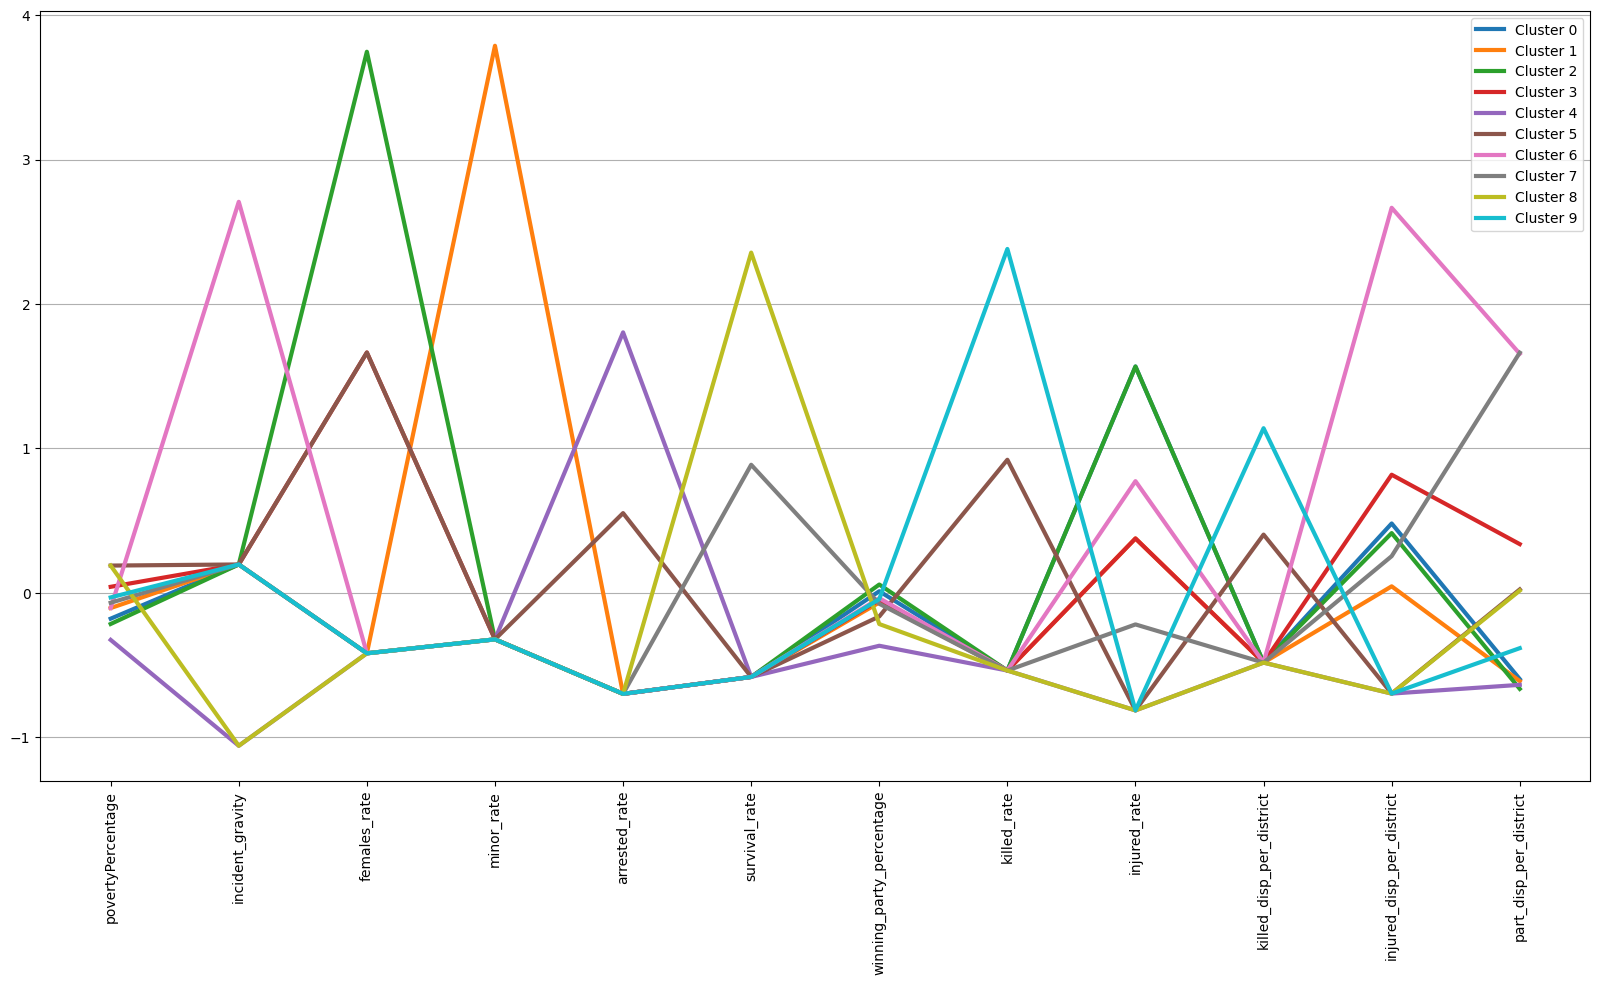

In [162]:
plt.figure(figsize=(20, 10))

for label in np.unique(labels_x):
    cent = df_numeric[labels_x == label].median()
    plt.plot(cent, label="Cluster %s" % label, linewidth=3)
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(df_numeric.columns)), df_numeric.columns, rotation=90)
plt.legend()
plt.gca().yaxis.grid(True)

plt.show()

Those plots give us a representation of some clusters defined by a particulare feature, others defined by a mix of features.

## Characterizing clusters with Cities (or Counties)

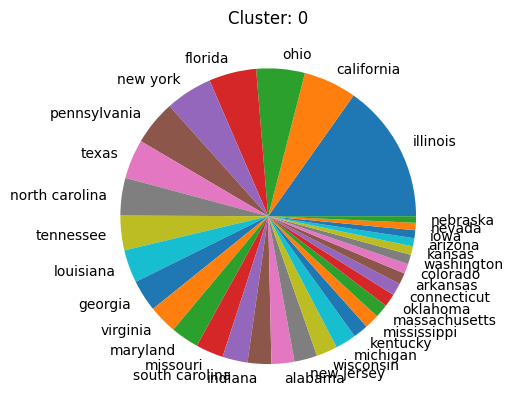

state
illinois          6648
california        2536
ohio              2320
florida           2268
new york          2248
pennsylvania      2143
texas             1883
north carolina    1796
tennessee         1652
louisiana         1579
georgia           1511
virginia          1371
maryland          1341
missouri          1326
south carolina    1200
indiana           1133
alabama           1094
new jersey        1094
wisconsin         1012
michigan           997
kentucky           716
mississippi        696
massachusetts      647
oklahoma           620
connecticut        595
arkansas           539
colorado           476
washington         453
kansas             411
arizona            389
iowa               379
nevada             351
nebraska           313
Name: count, dtype: int64


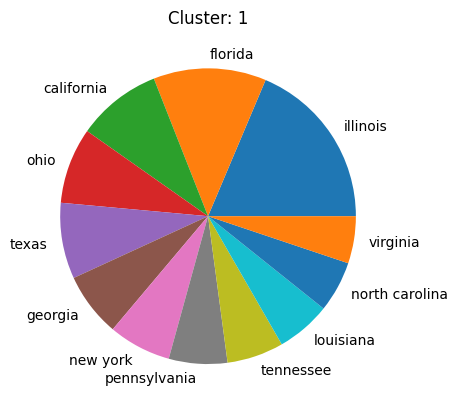

state
illinois          1092
florida            723
california         543
ohio               487
texas              487
georgia            410
new york           402
pennsylvania       375
tennessee          363
louisiana          349
north carolina     327
virginia           302
Name: count, dtype: int64


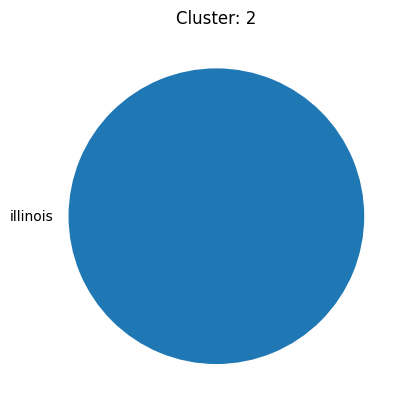

state
illinois    513
Name: count, dtype: int64


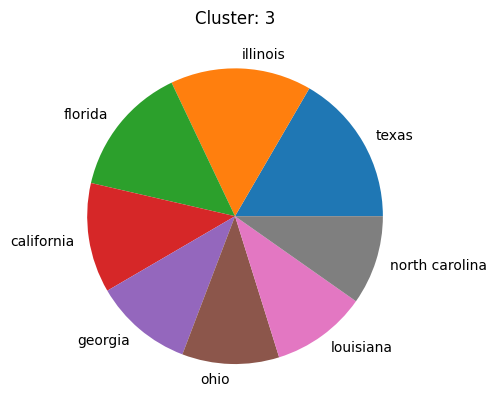

state
texas             523
illinois          486
florida           451
california        378
georgia           340
ohio              334
louisiana         328
north carolina    307
Name: count, dtype: int64


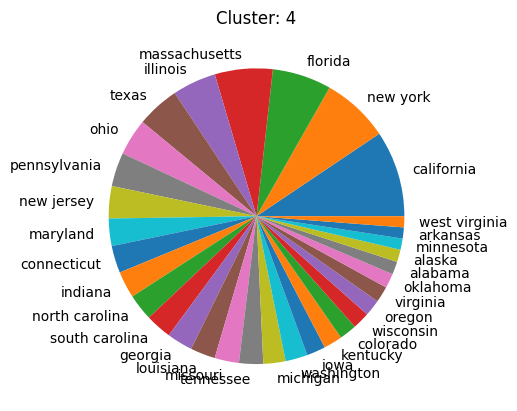

state
california        2441
new york          1908
florida           1674
massachusetts     1639
illinois          1242
texas             1212
ohio              1040
pennsylvania       959
new jersey         915
maryland           775
connecticut        771
indiana            758
north carolina     749
south carolina     743
georgia            731
louisiana          706
missouri           691
tennessee          683
michigan           629
washington         627
iowa               534
kentucky           531
colorado           492
wisconsin          482
oregon             467
virginia           455
oklahoma           413
alabama            365
alaska             352
minnesota          317
arkansas           314
west virginia      314
Name: count, dtype: int64


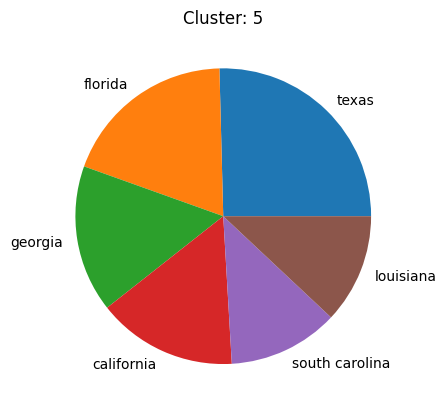

state
texas             646
florida           486
georgia           409
california        389
south carolina    307
louisiana         305
Name: count, dtype: int64


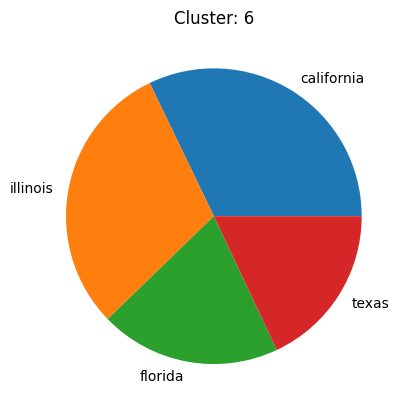

state
california    550
illinois      515
florida       338
texas         308
Name: count, dtype: int64


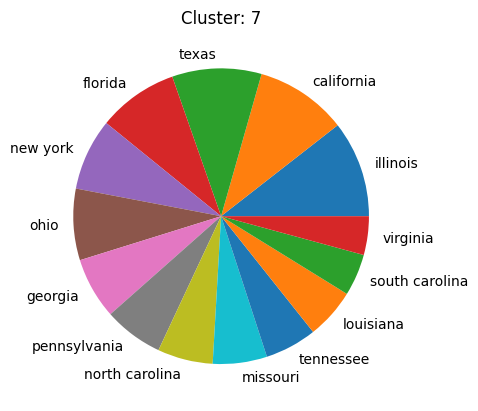

state
illinois          751
california        715
texas             696
florida           626
new york          559
ohio              556
georgia           479
pennsylvania      463
north carolina    431
missouri          422
tennessee         404
louisiana         392
south carolina    326
virginia          301
Name: count, dtype: int64


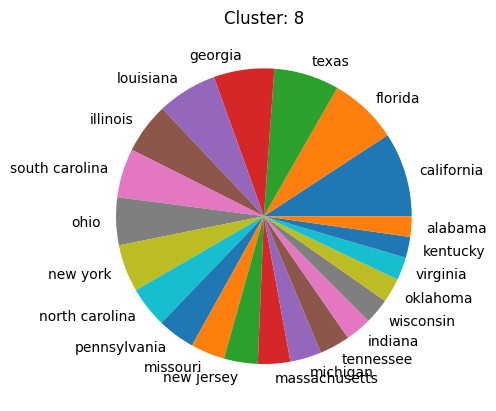

state
california        1343
florida           1090
texas             1039
georgia            963
louisiana          953
illinois           806
south carolina     781
ohio               758
new york           753
north carolina     652
pennsylvania       597
missouri           542
new jersey         537
massachusetts      514
michigan           498
tennessee          484
indiana            416
wisconsin          407
oklahoma           390
virginia           364
kentucky           332
alabama            327
Name: count, dtype: int64


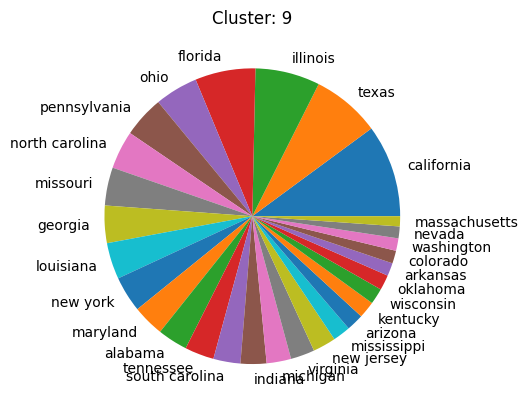

state
california        2903
texas             2151
illinois          2031
florida           1895
ohio              1354
pennsylvania      1300
north carolina    1201
missouri          1196
georgia           1174
louisiana         1143
new york          1126
maryland           993
alabama            942
tennessee          918
south carolina     850
indiana            813
michigan           769
virginia           754
new jersey         724
mississippi        553
arizona            537
kentucky           531
wisconsin          500
oklahoma           478
arkansas           408
colorado           402
washington         391
nevada             372
massachusetts      318
Name: count, dtype: int64


In [163]:
for k in range(0, n_clusters):
    # Get 'bot' values for elems in cluster k
    injury_for_clust = df_categorical['state'].loc[labels_x == k].value_counts() 
    injury_for_clust = injury_for_clust[injury_for_clust > 300]
    # Show pie plot
    plt.title('Cluster: ' + str(k))
    plt.pie(injury_for_clust, labels= injury_for_clust.index)
    plt.show()
    print(injury_for_clust)

We can notice a cluster with only Illinois incidents and the others are more balanced

##  Characterizing clusters with incident char

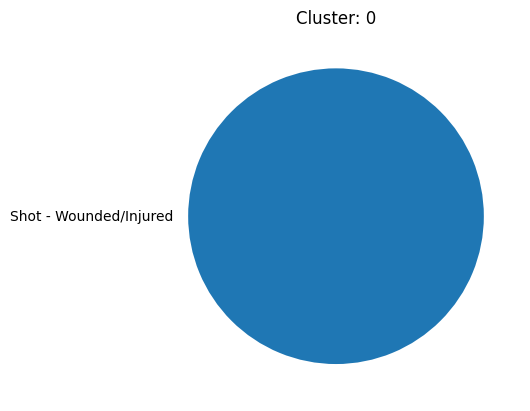

incident_characteristics1
Shot - Wounded/Injured    44510
Name: count, dtype: int64


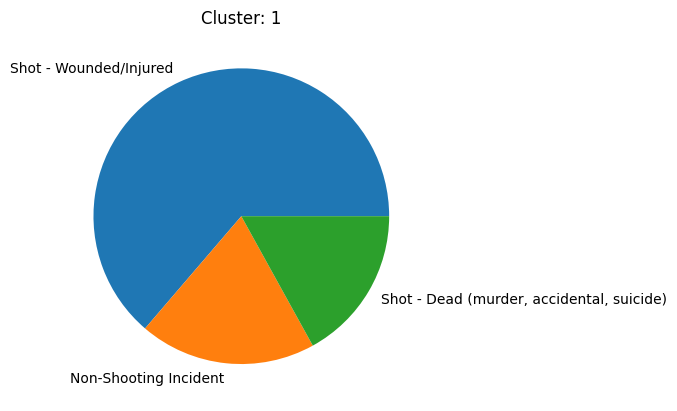

incident_characteristics1
Shot - Wounded/Injured                       5325
Non-Shooting Incident                        1614
Shot - Dead (murder, accidental, suicide)    1418
Name: count, dtype: int64


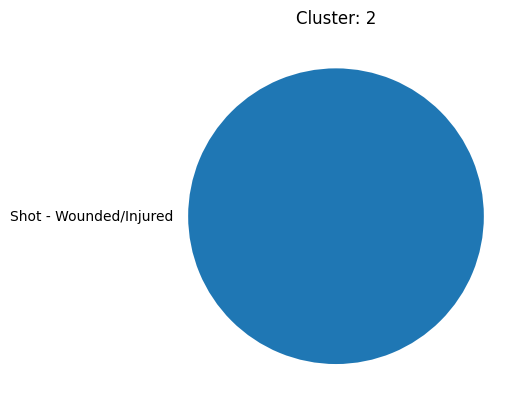

incident_characteristics1
Shot - Wounded/Injured    3374
Name: count, dtype: int64


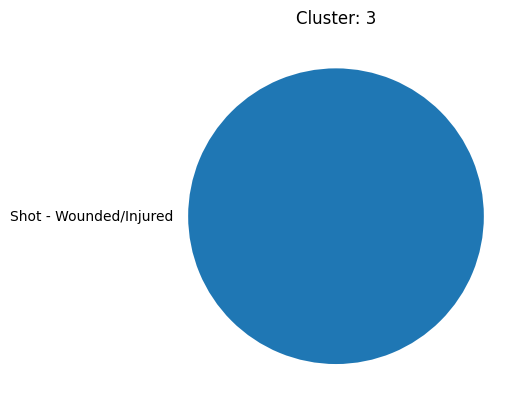

incident_characteristics1
Shot - Wounded/Injured    6536
Name: count, dtype: int64


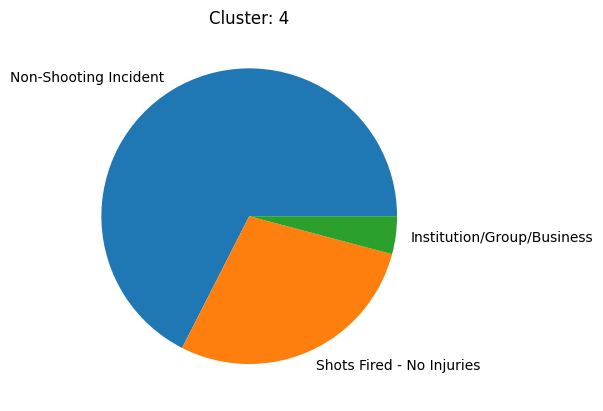

incident_characteristics1
Non-Shooting Incident         18260
Shots Fired - No Injuries      7673
Institution/Group/Business     1119
Name: count, dtype: int64


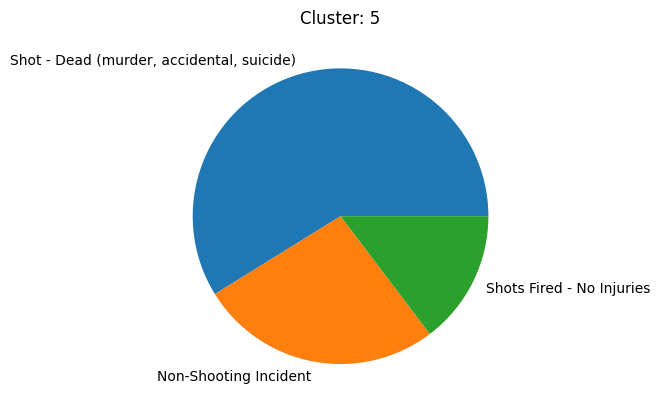

incident_characteristics1
Shot - Dead (murder, accidental, suicide)    4030
Non-Shooting Incident                        1815
Shots Fired - No Injuries                    1005
Name: count, dtype: int64


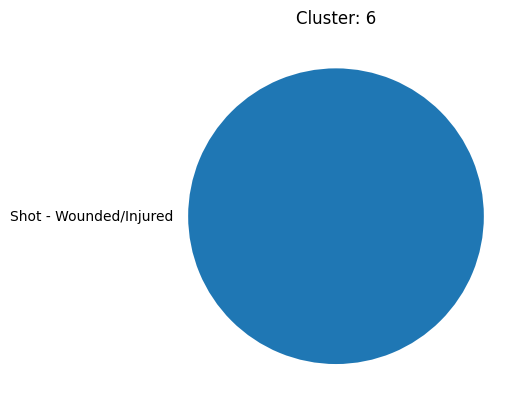

incident_characteristics1
Shot - Wounded/Injured    5086
Name: count, dtype: int64


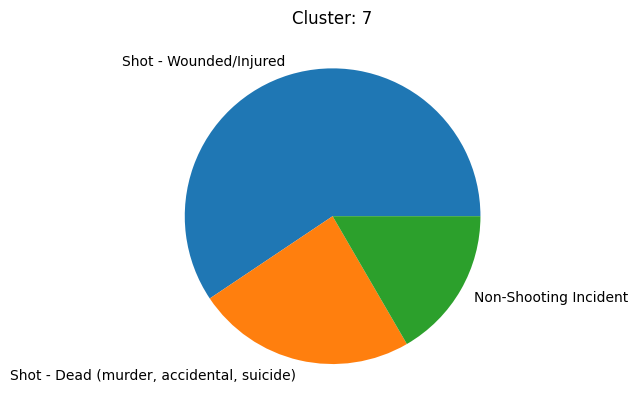

incident_characteristics1
Shot - Wounded/Injured                       5646
Shot - Dead (murder, accidental, suicide)    2280
Non-Shooting Incident                        1580
Name: count, dtype: int64


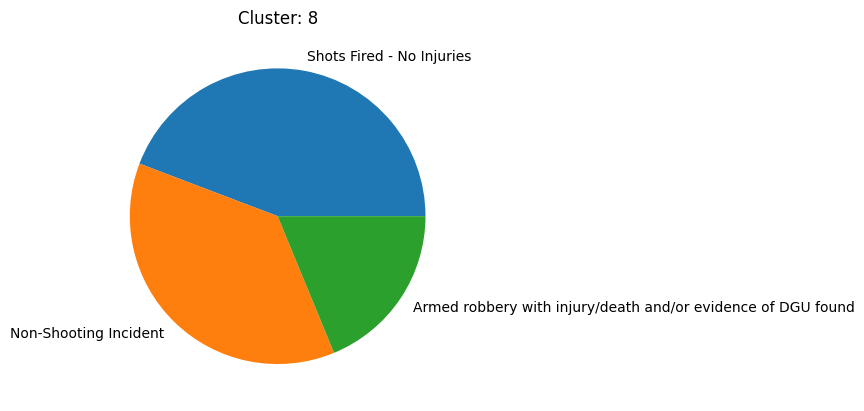

incident_characteristics1
Shots Fired - No Injuries                                       5730
Non-Shooting Incident                                           4797
Armed robbery with injury/death and/or evidence of DGU found    2433
Name: count, dtype: int64


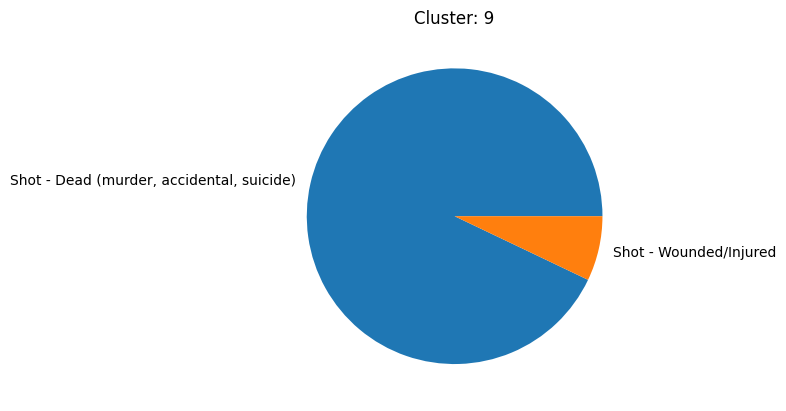

incident_characteristics1
Shot - Dead (murder, accidental, suicide)    28554
Shot - Wounded/Injured                        2177
Name: count, dtype: int64


In [164]:
for k in range(0, n_clusters):
    # Get 'bot' values for elems in cluster k
    incident_char_clust = df_categorical['incident_characteristics1'].loc[ labels_x == k].value_counts() 
    incident_char_clust = incident_char_clust[incident_char_clust > 800]
    # Show pie plot
    plt.title('Cluster: ' + str(k))
    plt.pie(incident_char_clust, labels= incident_char_clust.index)
    plt.show()
    print(incident_char_clust)

## Characterizing clusters with arrested, unharmed, killing, injuried

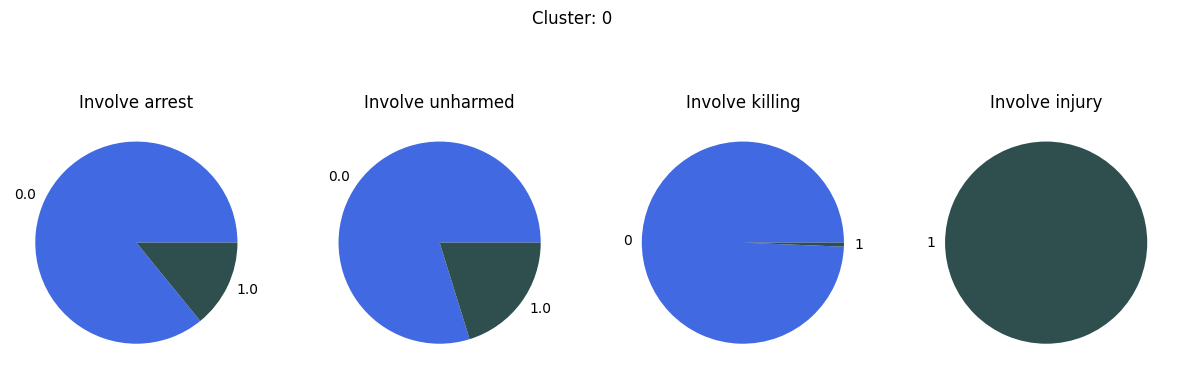

involve_arrest
0.0    39043
1.0     6415
Name: count, dtype: int64

involve_unharmed
0.0    36273
1.0     9185
Name: count, dtype: int64

isKilled
0    45167
1      291
Name: count, dtype: int64

involve_injury
1    45458
Name: count, dtype: int64


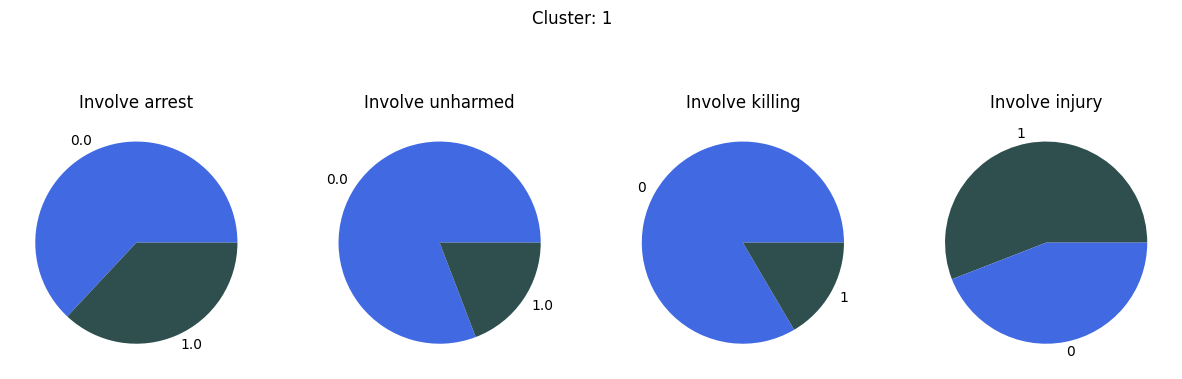

involve_arrest
0.0    6091
1.0    3572
Name: count, dtype: int64

involve_unharmed
0.0    7809
1.0    1854
Name: count, dtype: int64

isKilled
0    8065
1    1598
Name: count, dtype: int64

involve_injury
1    5401
0    4262
Name: count, dtype: int64


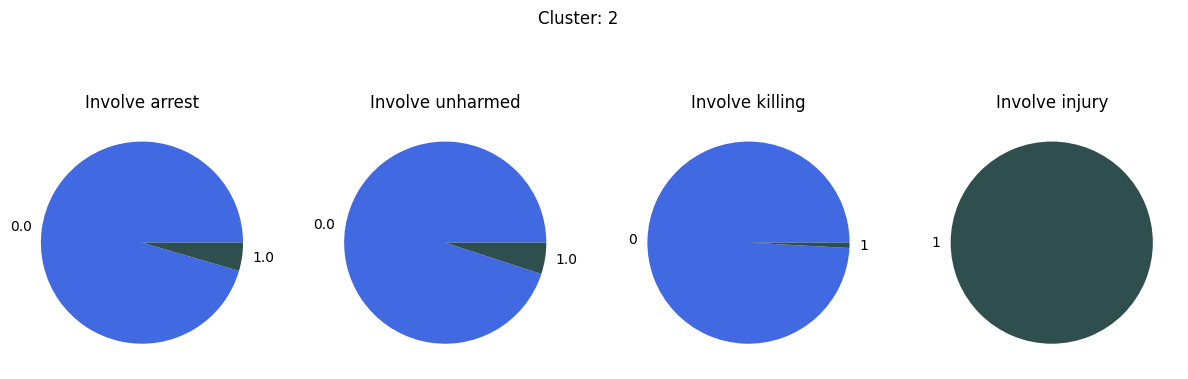

involve_arrest
0.0    3269
1.0     154
Name: count, dtype: int64

involve_unharmed
0.0    3251
1.0     172
Name: count, dtype: int64

isKilled
0    3394
1      29
Name: count, dtype: int64

involve_injury
1    3423
Name: count, dtype: int64


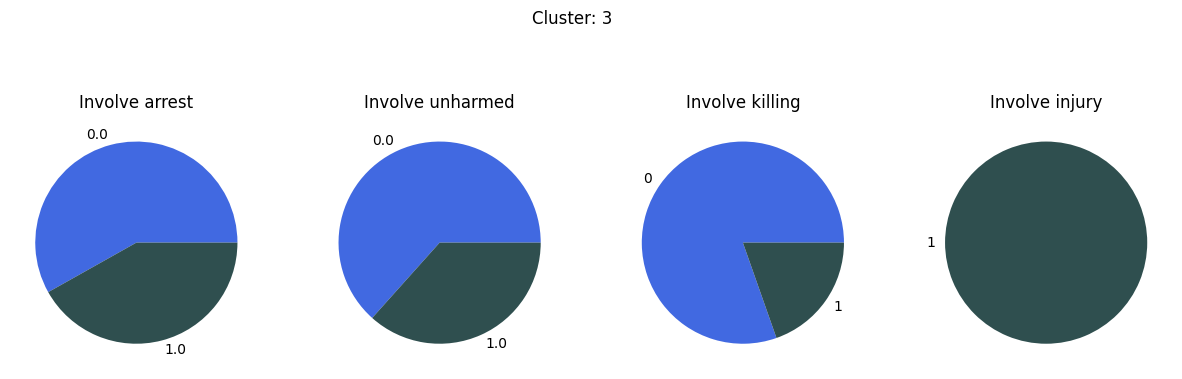

involve_arrest
0.0    4122
1.0    2967
Name: count, dtype: int64

involve_unharmed
0.0    4493
1.0    2596
Name: count, dtype: int64

isKilled
0    5699
1    1390
Name: count, dtype: int64

involve_injury
1    7089
Name: count, dtype: int64


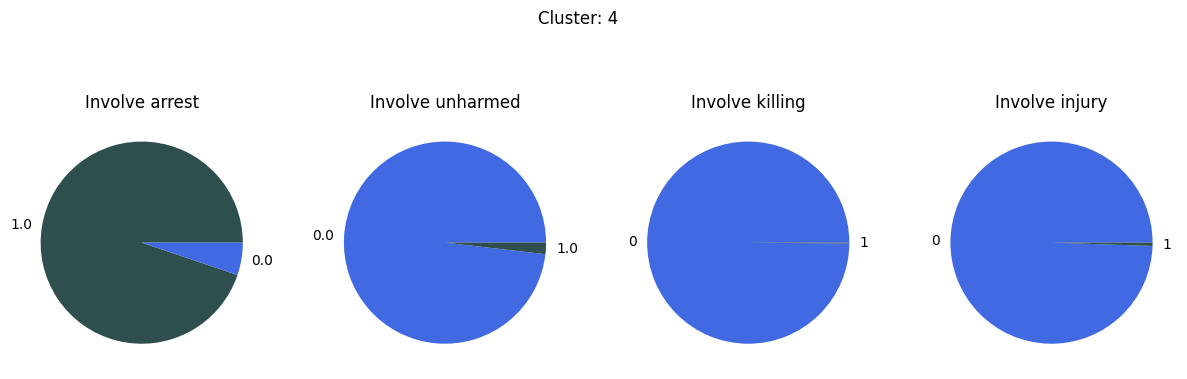

involve_arrest
1.0    26991
0.0     1478
Name: count, dtype: int64

involve_unharmed
0.0    27950
1.0      519
Name: count, dtype: int64

isKilled
0    28429
1       40
Name: count, dtype: int64

involve_injury
0    28320
1      149
Name: count, dtype: int64


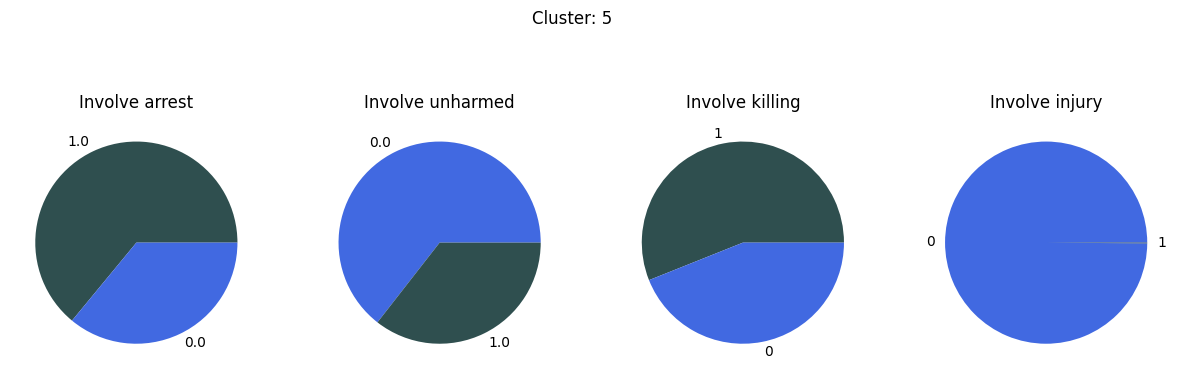

involve_arrest
1.0    4658
0.0    2618
Name: count, dtype: int64

involve_unharmed
0.0    4690
1.0    2586
Name: count, dtype: int64

isKilled
1    4078
0    3198
Name: count, dtype: int64

involve_injury
0    7268
1       8
Name: count, dtype: int64


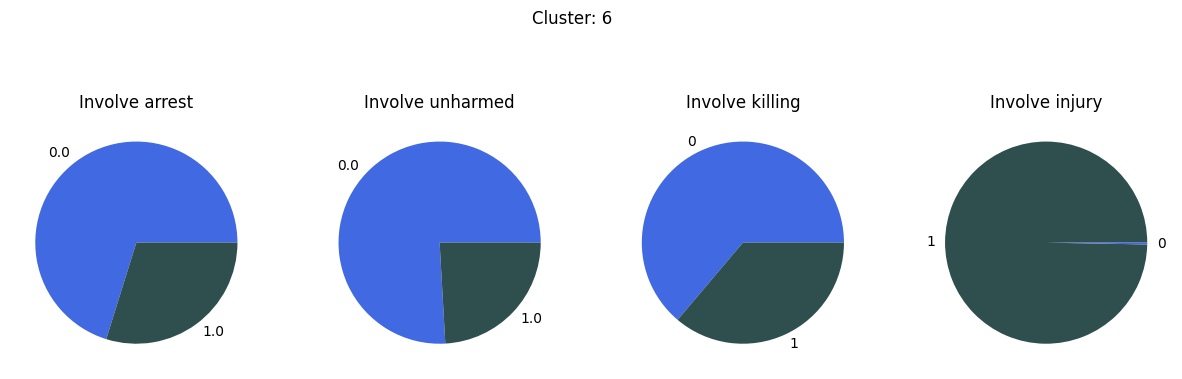

involve_arrest
0.0    3681
1.0    1564
Name: count, dtype: int64

involve_unharmed
0.0    3981
1.0    1264
Name: count, dtype: int64

isKilled
0    3348
1    1897
Name: count, dtype: int64

involve_injury
1    5230
0      15
Name: count, dtype: int64


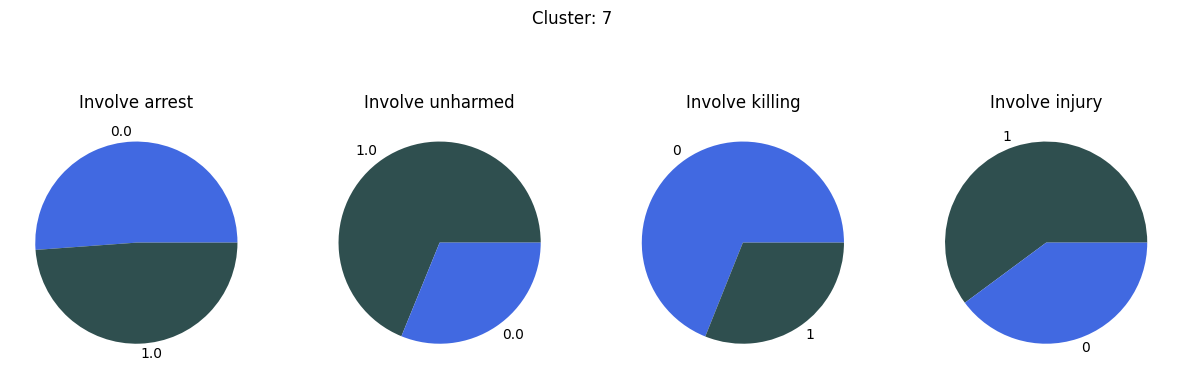

involve_arrest
0.0    5542
1.0    5293
Name: count, dtype: int64

involve_unharmed
1.0    7458
0.0    3377
Name: count, dtype: int64

isKilled
0    7469
1    3366
Name: count, dtype: int64

involve_injury
1    6516
0    4319
Name: count, dtype: int64


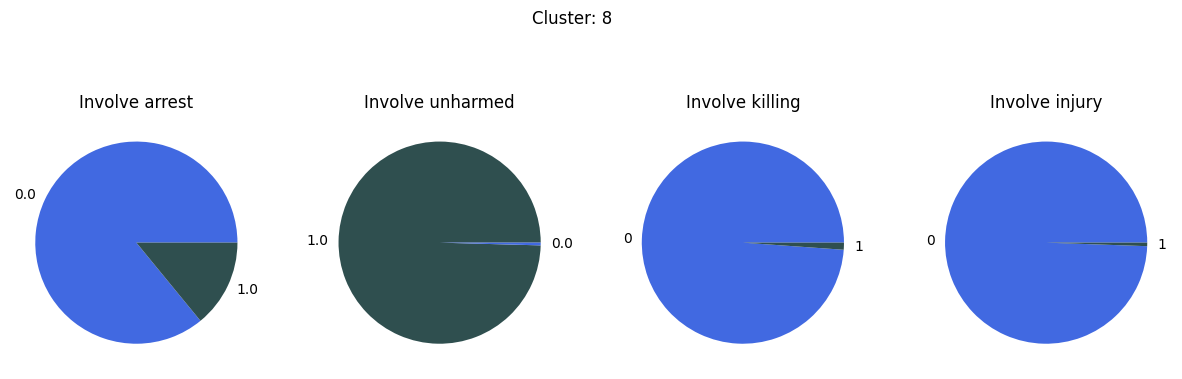

involve_arrest
0.0    15683
1.0     2567
Name: count, dtype: int64

involve_unharmed
1.0    18171
0.0       79
Name: count, dtype: int64

isKilled
0    18045
1      205
Name: count, dtype: int64

involve_injury
0    18148
1      102
Name: count, dtype: int64


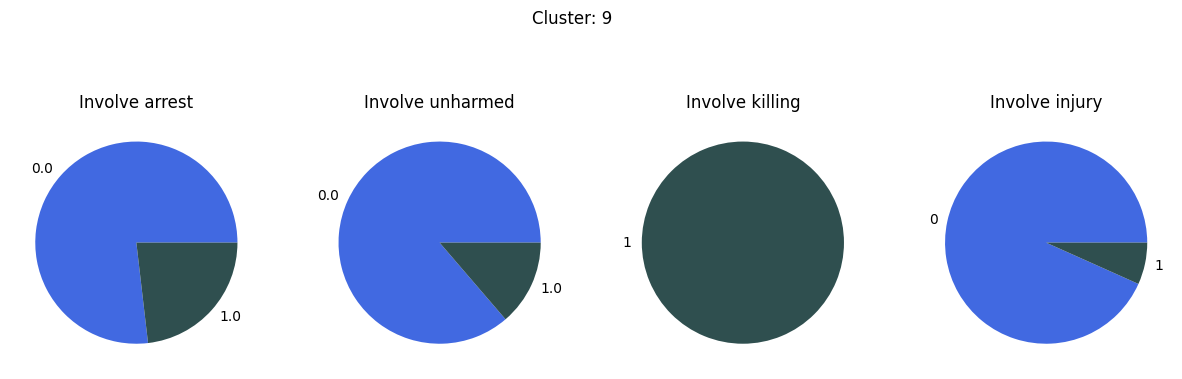

involve_arrest
0.0    23788
1.0     7168
Name: count, dtype: int64

involve_unharmed
0.0    26716
1.0     4240
Name: count, dtype: int64

isKilled
1    30956
Name: count, dtype: int64

involve_injury
0    28883
1     2073
Name: count, dtype: int64


In [165]:

for k in range(0, n_clusters):
    # Get 'bot' values for elems in cluster k
    
    n_arrested_clust =  df_categorical["involve_arrest"].loc[labels_x == k].value_counts()
    n_unharmed_clust = df_categorical['involve_unharmed'].loc[labels_x  == k].value_counts() 
    n_killed_clust = df_categorical['isKilled'].loc[labels_x== k].value_counts()
    n_injured_clust = df_categorical['involve_injury'].loc[labels_x == k].value_counts()

    #showing the two pie plots together
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.suptitle('Cluster: ' + str(k))
    fig.set_figwidth(15)
    ax1.pie(n_arrested_clust, labels= n_arrested_clust.index, colors=get_colors(n_arrested_clust))
    ax2.pie(n_unharmed_clust, labels= n_unharmed_clust.index, colors=get_colors(n_unharmed_clust))
    ax3.pie(n_killed_clust, labels= n_killed_clust.index, colors=get_colors(n_killed_clust))
    ax4.pie(n_injured_clust, labels= n_injured_clust.index, colors=get_colors(n_injured_clust))

    #adding ax1 and ax2 titles
    ax1.set_title('Involve arrest')
    ax2.set_title('Involve unharmed')
    ax3.set_title('Involve killing')
    ax4.set_title('Involve injury')

    #change the colors of the pie plots
    

    plt.show()

    print(n_arrested_clust)
    print()
    print(n_unharmed_clust)
    print()
    print(n_killed_clust)
    print()
    print(n_injured_clust)


We notice fewer differences between the clusters compared to KMeans. However, we can identify three clusters that consist entirely of incidents involving only injuries, which aligns with the incident characteristics observed within those clusters. One cluster involves injuries along with many unharmed individuals and numerous arrests. Another cluster predominantly includes unharmed participants. There's also a cluster exclusively involving fatalities, likely suicides, where all participants are deceased. The remaining clusters exhibit a more balanced mix of incident types.

# Best clustering method
From our experiments we obtained the best performances from the K-Means Clustering, so we selected it as our final method by looking at the distribution of the clusters and to the distribution of incidents involving precence or absence of arrested, killed, unharmed, injuried.